# Load in modules

In [74]:
import keras 
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from keras.layers import Conv2D, MaxPool2D, AvgPool2D, Dropout, Dense, BatchNormalization, Identity, Input, GlobalAveragePooling2D, \
            RandomBrightness, RandomSharpness, RandomInvert, RandomRotation, RandomFlip
from keras.activations import relu
from keras.optimizers import AdamW
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


# Create class for the model

In [91]:
class ImproveContrast(keras.layers.Layer):
    def __init__(self, alpha=0.2):
        super().__init__()
        self.alpha = alpha
    
    def call(self, x):
        x = (x-self.alpha)**2
        x = tf.where(x < 0, 0.0, x)
        return x

In [92]:
#Code for Resnet block
class ResBlock(keras.layers.Layer):
    def __init__(self, num_input_layers, num_output_layers, kernel_size):
        super().__init__()
        #For first convolutional layer
        self.conv1 = Conv2D(num_output_layers, kernel_size=kernel_size, padding='same', strides=1, 
                                  kernel_initializer='glorot_uniform')
        self.bn1 = BatchNormalization()
        self.relu = relu

        #For second convolutional layer
        self.conv2 = Conv2D(num_output_layers, kernel_size=kernel_size, padding='same', strides=1, 
                                  kernel_initializer='glorot_uniform')
        self.bn2 = BatchNormalization()

        #If the input and output channels are different, we need to adjust the input
        if num_input_layers != num_output_layers:
            self.shortcut = Conv2D(num_output_layers, kernel_size=1, strides=1, padding='valid')
        else:
            self.shortcut = Identity()
    
    def call(self, x):
        #First convolutional layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        #Second convolutional layer
        x = self.conv2(x)
        x = self.bn2(x)

        #Add shortcut and apply non-linearity
        x += self.shortcut(x)
        x = self.relu(x)

        return x

In [93]:
class CNN(keras.Model):
    """Convolutional Neural Network class using residual network blocks"""
    def __init__(self, input_shape=[75, 75, 1], batch_size=64, mode='regression'):
        if not isinstance(input_shape, list):
            raise TypeError("input_shape type must be of type 'List'")
         
        if (mode != 'regression') and (mode != 'classification'): #Make shure the mode is always correct
            raise ValueError("The mode of the CNN can either be 'regression' or 'classification'")
        
        if not isinstance(batch_size, int):
            raise TypeError("The batch size must be of type 'int'")

        super().__init__()
        #Just some parameters to keep just in case it is needed later
        self.input_shape = tuple([batch_size] + input_shape)
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.mode = mode

        self.conv_layers = keras.Sequential([
                Input(shape=(self.input_shape)),
                ImproveContrast(0.2),
                ResBlock(num_input_layers=3, num_output_layers=16, kernel_size=3 ),
                Conv2D(16, kernel_size=2, padding='valid', strides=2),

                ResBlock(16, 32, 3),
                MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'),

                ResBlock(32, 64, 3),
                MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'),

                ResBlock(64, 128, 3),
                MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'),

                ResBlock(128, 256, 3),
                MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'),

                ResBlock(256, 512, 3),
                GlobalAveragePooling2D(data_format='channels_last')
        ])

        ############################################################################################################
        """This is the block containing Feed Forward layers for the regression part of the assignment, 
        make a similar block for classification"""

        self.regression_layers = keras.Sequential([
            Input((512, )),
            Dense(256, activation='relu', kernel_initializer='RandomNormal'),
            Dropout(0.5),
            Dense(128, activation='relu', kernel_initializer='RandomNormal'),
            Dropout(0.4),
            Dense(64, activation='relu', kernel_initializer='RandomNormal'),
            Dropout(0.3),
            Dense(1, activation='sigmoid', kernel_initializer='RandomNormal')
        ])

        ###########################################################################################################
        """"You can use this to create a block that is used for classification."""
        # self.classification_layers = keras.Sequential([
        #     Input((512, )),
        #     ...
        # ])


    def call(self, x):
        x = self.conv_layers(x)
        if self.mode == 'regression':
            x = 12 * self.regression_layers(x)
        else:
            x = self.classification_layers(x)
        return x



# Loss function for regression

our loss function for the regression is defined as $L[\phi] = - \displaystyle\sum_{i=1} ^{I} ln(1 + cos(\Theta(x_{i}, \phi)))$, where $\Theta(x_{i}, \phi) = \frac{\pi}{6}(f(x_{i}, \phi) - y_{i})$ with $f(x_{i}, \phi) \wedge y_{i} \in [0, 12]$

In [147]:
def Loss(y, pred):
    x = tf.experimental.numpy.pi * (pred - y) / 6
    l = tf.reduce_mean(tf.math.log(1 + tf.cos(x) + 1e-7))
    return l

In [150]:
def Loss(y, pred):
    theta_pred = 2 * tf.experimental.numpy.pi * pred / 12
    theta_true = 2 * tf.experimental.numpy.pi * y / 12
    d = tf.atan2(tf.sin(theta_pred - theta_true), tf.cos(theta_pred - theta_true))
    l = tf.reduce_mean(d**2)
    return l

We also need to define a function for the 'commen sense' accuracy

In [ ]:
def CS_MSE(y, pred): 
    '''This is the commen sense MSE, taking into acount that the values lie on a cirkel'''
    diff = (tf.math.mod(pred - y + 6, 12) - 6)
    MSE = tf.reduce_mean(diff**2)
    return MSE


# Load in data for regression

For now we will use the images with a resolution of 75x75, as it is faster to train the network on that

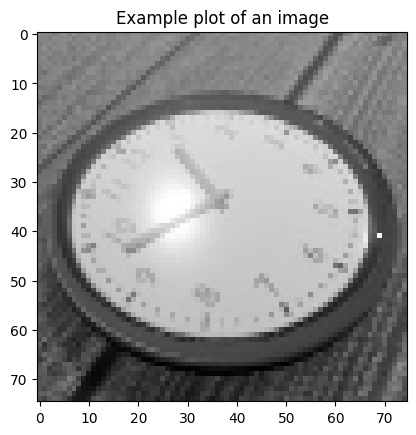

In [135]:
#Converted the image values to a range of [0, 1], better for network to work with
X, y = np.load('data_75/images.npy')/255.0, np.load('data_75/labels.npy')
# Augment y to be in R
y = (y[:,0] +  y[:,1]*1/60).astype(np.float32)

plt.title('Example plot of an image')
plt.imshow(X[1200], cmap='grey')


Text(0.5, 1.0, 'Inverted grayscale image')

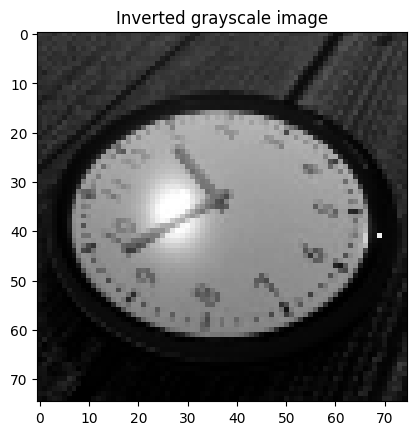

In [136]:
x = (X[1200]-0.2)**2
x[x < 0] = 0
x = np.expand_dims(x, axis=-1)
plt.imshow(x, cmap='grey')
plt.title('Inverted grayscale image')


# Start training for regression

### Split data into train/validation/test set

In [137]:
# Split data into 80/10/10% train/validation/test split
data_train, data_temp = keras.utils.split_dataset((X, y), 0.8, shuffle=True, seed=2024)
data_valid, data_test = keras.utils.split_dataset(data_temp, 0.5, shuffle=True, seed=2024)

#Convert iterable back to images -> (samples, 75, 75), labels -> (sampels, 2)
X_train, y_train = next(iter(data_train.batch(len(data_train))))
X_valid, y_valid = next(iter(data_valid.batch(len(data_valid))))
X_test, y_test = next(iter(data_test.batch(len(data_test))))

### Now compile a CNN model and train it on the data

In [ ]:
BATCH_SIZE = 128
NUM_EPOCHS = 75

preprocess = keras.Sequential([
        RandomFlip('horizontal_and_vertical'),
        RandomRotation(0.2),
        RandomSharpness((0.5, 0.75), value_range=(0,1)),
        RandomBrightness((-0.2, 0.2), value_range=(0,1)),
        RandomInvert(0.1, value_range=(0,1))
    ])

def DataAugment(img, label):
    if len(img.shape) == 2:
        img = tf.expand_dims(img, axis=-1)
    img = preprocess(img)
    return img, label
    
train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
            .shuffle(1000)
            .map(DataAugment, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE)
            )

valid_ds = (tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE)
            )


model_filepath = './task_2/checkpoint.model.keras'
callback = [ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3), 
            EarlyStopping(patience=10), 
            ModelCheckpoint(filepath=model_filepath, monitor='val_loss', save_best_only=True, mode='min')]

optim = AdamW(learning_rate=0.001)

model = CNN(input_shape=[75,75,1], batch_size=BATCH_SIZE, mode='regression')
model.compile(optimizer=optim, loss=)

model.fit(train_ds, validation_data=valid_ds, epochs=NUM_EPOCHS, callbacks=callback)


Epoch 1/75
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 214ms/step - loss: -12.0313 - val_loss: -11.6874 - learning_rate: 0.0010
Epoch 2/75
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 221ms/step - loss: -12.0642 - val_loss: -11.6874 - learning_rate: 0.0010
Epoch 3/75
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 221ms/step - loss: -12.0642 - val_loss: -11.6874 - learning_rate: 0.0010
Epoch 4/75
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 222ms/step - loss: -12.0642 - val_loss: -11.6874 - learning_rate: 0.0010
Epoch 5/75
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 221ms/step - loss: -12.0642 - val_loss: -11.6874 - learning_rate: 2.0000e-04
Epoch 6/75
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 221ms/step - loss: -12.0642 - val_loss: -11.6874 - learning_rate: 2.0000e-04
Epoch 7/75
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 221ms/step - loss: -12.0642 - val_loss: -11.6874 - learning_rate: 2.0000e-04
Epoch 8/75
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 221ms/step - loss: -12.0642 - val_loss: -11.6874 - learning_rate: 4.0000e-05
Epoch 9/75
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 221m